#📌 Extracción

Los datos fueron extraídos de un archivo JSON y normalizados en un DataFrame de Pandas

In [11]:
import pandas as pd
import numpy as np
import requests

url='https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json'
response=requests.get(url)
datos_json=response.json()

#🔧 Transformación

Durante esta fase, se realizó una limpieza inicial para estandarizar los nombres de las columnas y convertir la columna TotalCharges (Cargos Totales) a un formato numérico, identificando y tratando 11 valores nulos como clientes nuevos (cero cargos)

In [12]:
df=pd.json_normalize(datos_json)
#1-)vemos como se llaman realamente las columnas de cargos
print("Columnas detectadas que contienen 'Charges':")
print([col for col in df.columns if 'Charges' in col])
#2-)elimino los prefijos repetitivos como customer ,phone etc
df.columns = [col.split('.')[-1] for col in df.columns]
print(df.columns)
#Convertimos Cargo_Total a numero.'coerce'transforma espacios vacios en nulos
df['TotalCharges'] = pd.to_numeric(df['Total'], errors='coerce')
# 5. Visualización rápida de la salud de los datos
print("Estructura del dataset:", df.shape)
print("\nTipos de datos y nulos:")
print(df.info())




Columnas detectadas que contienen 'Charges':
['account.Charges.Monthly', 'account.Charges.Total']
Index(['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'tenure', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Monthly', 'Total'],
      dtype='object')
Estructura del dataset: (7267, 22)

Tipos de datos y nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   

Tenemos clientes que No se han ido (71.2%), otros que Sí se han ido (25.7%), y un pequeño grupo (3.1%) donde no sabemos si se fueron o no porque el dato está vacio. Esos valores vacíos son importantes y tendremos que decidir como manejarlos.

In [15]:
#1-)Manejo de nulos en TotalCharges
#Como son clientes nuevos lo lgico es que su total gastado sea 0
df['TotalCharges'] = df['TotalCharges'].fillna(0)
#2-)Limpieza de textos (Inconsistencias)
#A veces los datos traen espacios extra al inicio o final que rompen el analisis
#Aplicamos una limpieza general a todas las columnas de texto
columnas_objeto =df.select_dtypes(include=['object']).columns
for col in columnas_objeto:
    df[col] = df[col].str.strip()
#3-)Verificación de la columna objetivo (Churn)
print("Valores unicos en la columna de abandono (Churn):")
print(df['Churn'].unique())

# 4-)Cuntos se van vs cuántos se quedan
print("\nCuntos se van vs cuántos se quedan\nDistribución de la desercion:")
print(df['Churn'].value_counts(normalize=True) * 100)






Valores unicos en la columna de abandono (Churn):
['No' 'Yes' '']

Cuntos se van vs cuántos se quedan
Distribución de la desercion:
Churn
No     71.198569
Yes    25.719004
        3.082427
Name: proportion, dtype: float64


el DataFrame df ahora esta limpio, sin duplicados ni valores nulos, y con los tipos de datos correctos, listo para las siguientes fases de analisis y modelado

In [16]:
#1-)Verificacion de Duplicados
duplicados = df.duplicated().sum()
print(f"Cantidad de registros duplicados: {duplicados}")

#Si hubiera duplicados, los eliminaríamos así:
#df = df.drop_duplicates()

#2-)Verificacion de Nulos tras la limpieza
print("\nConteo de valores nulos por columna:")
print(df.isnull().sum())

# 3-)Tratamiento especifico para 'TotalCharges' (Cargo_Total)
#Vamos a ver cuantos son nulos
nulos_totales=df['TotalCharges'].isnull().sum()

if nulos_totales > 0:
    print(f"\nTratando {nulos_totales} nulos en TotalCharges...")
    #Llenamos con 0, asumiendo que son clientes nuevos
    df['TotalCharges'] = df['TotalCharges'].fillna(0)
    print("¡Nulos convertidos a 0 con exito!")

#4-)Verificacion final de tipos de datos
print("\nEstado final de los tipos de datos:")
df.info()

Cantidad de registros duplicados: 0

Conteo de valores nulos por columna:
customerID          0
Churn               0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
Monthly             0
Total               0
TotalCharges        0
dtype: int64

Estado final de los tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4 

convierto todo la columnas que aparecen en comentarios

In [18]:
#1-)Copia de seguridad del dataset limpio
df_procesado = df.copy()

#2-)Convierto Churn a binario Yes=1 No=0
#Esto es fundamental para poder calcular correlaciones despues
diccionario_binario = {'Yes': 1, 'No': 0}
df_procesado['Churn'] = df_procesado['Churn'].map(diccionario_binario)

#3-)Identificar otras columnas binarias para transformar
#Por ejemplo: Partner, Dependents, PhoneService, PaperlessBilling
columnas_si_no = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

for col in columnas_si_no:
    df_procesado[col] = df_procesado[col].map(diccionario_binario)

#4-)Verificación de los cambios
print("Nuevos valores en Churn:", df_procesado['Churn'].unique())
print("\nPrimeras filas transformadas:")
display(df_procesado[['Churn', 'Partner', 'Dependents']].head())

Nuevos valores en Churn: [ 0.  1. nan]

Primeras filas transformadas:


,Churn,Partner,Dependents
0,0.0,1,1
1,0.0,0,0
2,1.0,0,0
3,1.0,1,0
4,1.0,1,0


#📊 Carga y análisis

ahora estamos listos para graficar

| Variable         | Correlación | Lectura comercial                       |
| ---------------- | ----------- | --------------------------------------- |
| **tenure**       | **-0.35**   | 🔴 **La mas importante**                |
| MonthlyCharges   | +0.19       | Clientes con facturas altas se van mss  |
| PaperlessBilling | +0.19       | Clientes digitales tienen mss churn     |
| SeniorCitizen    | +0.15       | Adultos mayores cancelan mas            |
| Partner          | -0.15       | Tener pareja reduce churn               |
| Dependents       | -0.16       | Tener dependientes reduce churn         |
| TotalCharges     | -0.20       | Clientes que ya pagaron mucho se quedan |


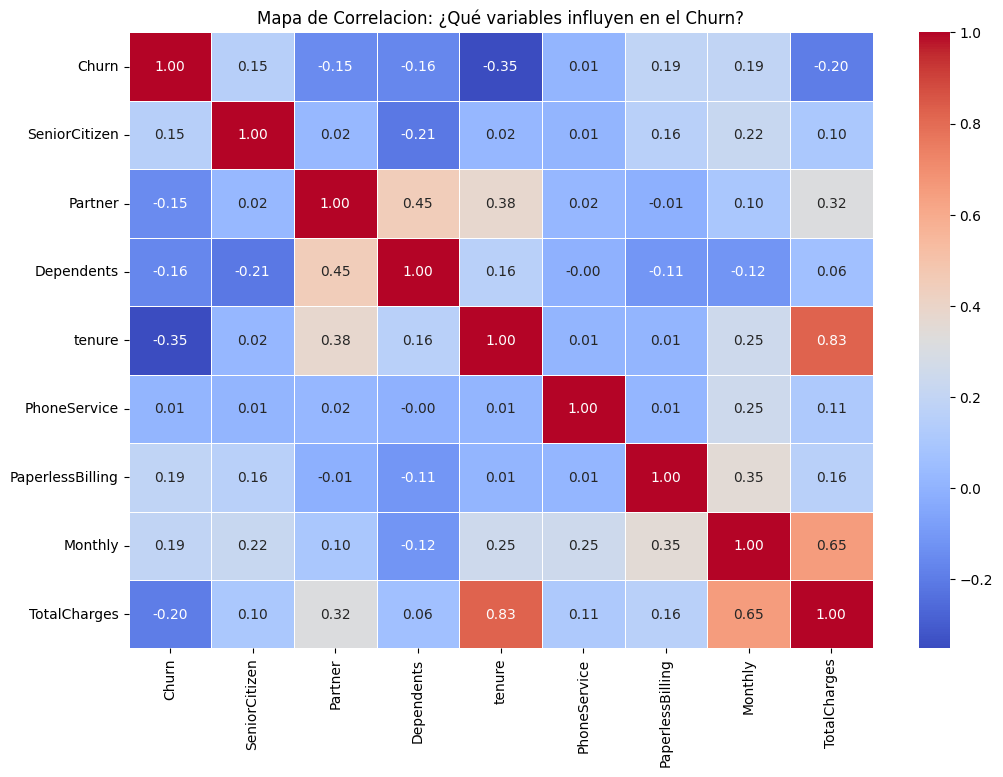

Correlacion de las variables con respecto al Abandono Churn:
Churn               1.000000
Monthly             0.193356
PaperlessBilling    0.191825
SeniorCitizen       0.150889
PhoneService        0.011942
Partner            -0.150448
Dependents         -0.164221
TotalCharges       -0.198324
tenure             -0.352229
Name: Churn, dtype: float64


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

#1-)Seleccionamos solo las columnas que ya son numericas
#(Churn, tenure, Monthly, TotalCharges, Partner, etc.)
df_numerico = df_procesado.select_dtypes(include=[np.number])

#2-)Calculamos la matriz de correlacion
corr = df_numerico.corr()

#3-)Creamos el grafico
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Mapa de Correlacion: ¿Qué variables influyen en el Churn?")
plt.show()

#4-)Ranking de correlacion con Churn
print("Correlacion de las variables con respecto al Abandono Churn:")
print(corr['Churn'].sort_values(ascending=False))

El churn esta impulsado principalmente por:

Baja antiguedad

Precio mensual elevado

Poco vínculo relacional (clientes digitales)

#📄Informe final